In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import string
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Load datasets
supervised_data = pd.read_csv('/content/drive/MyDrive/output.csv')
unsupervised_train = pd.read_json('/content/drive/MyDrive/webis-clickbait-22/train.jsonl', lines=True)
unsupervised_val = pd.read_json('/content/drive/MyDrive/webis-clickbait-22/validation.jsonl', lines=True)

In [3]:
# Separate features and labels
X = supervised_data[' title']
y = supervised_data['label']

In [4]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [6]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=100)
X_test_padded = pad_sequences(X_test_seq, maxlen=100)

In [8]:
# Build and compile the complex RNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(GRU(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(SimpleRNN(64, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

In [11]:
# Train the RNN model with validation data
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 310s 420ms/step - accuracy: 0.8547 - loss: 0.6499 - val_accuracy: 0.9687 - val_loss: 0.2451 - learning_rate: 0.0010
Epoch 2/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 313s 407ms/step - accuracy: 0.9802 - loss: 0.1920 - val_accuracy: 0.9676 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 316s 399ms/step - accuracy: 0.9886 - loss: 0.0992 - val_accuracy: 0.9703 - val_loss: 0.1494 - learning_rate: 0.0010
Epoch 4/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 297s 412ms/step - accuracy: 0.9913 - loss: 0.0593 - val_accuracy: 0.9738 - val_loss: 0.1550 - learning_rate: 0.0010
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 319s 409ms/step - accuracy: 0.9929 - loss: 0.0465 - val_accuracy: 0.9359 - val_loss: 0.3877 - learning_rate: 0.0010
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 319s 404ms/step - accuracy: 0.9916 - loss: 0.0514 - val_accuracy: 0.9687 - val_loss: 0.1330 - learning_rate: 0.0010
Epoch 7/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 319s 400ms/step - accura

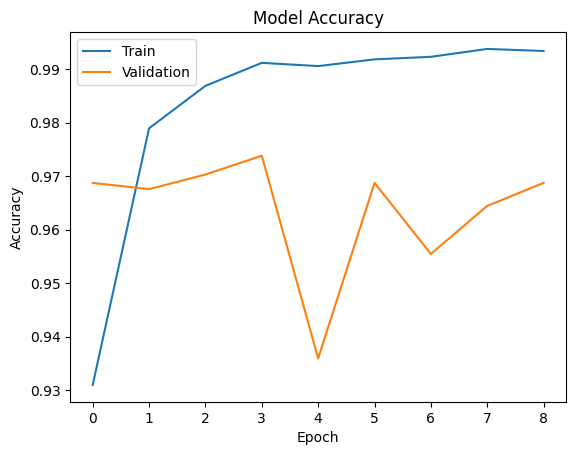

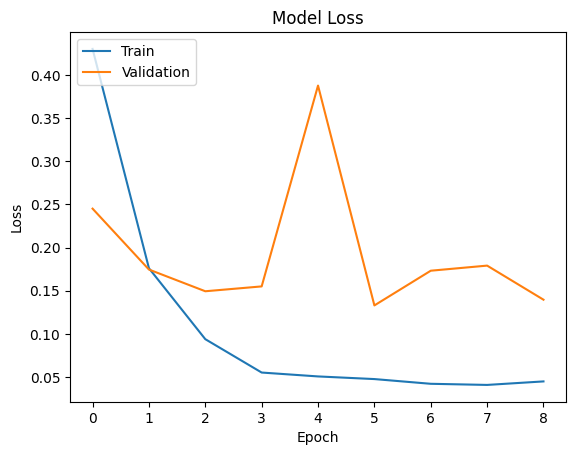

In [12]:
# Plotting accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:

# Evaluate the RNN model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test accuracy: {test_accuracy}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.9720 - loss: 0.1080
Test accuracy: 0.9696780443191528


In [14]:
# Predict on the test set
y_test_pred_probs = model.predict(X_test_padded)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step


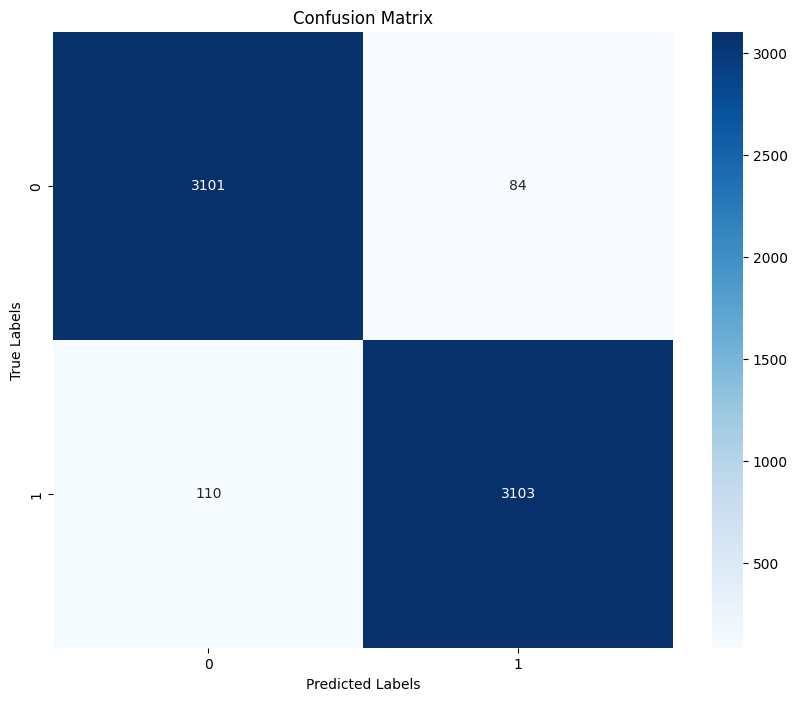

In [15]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Extract relevant text features from the unsupervised datasets
X_unlabeled_train = unsupervised_train['postText'].astype(str)
X_unlabeled_val = unsupervised_val['postText'].astype(str)

In [17]:
# Tokenize and pad the unsupervised data
X_unlabeled_train_seq = tokenizer.texts_to_sequences(X_unlabeled_train)
X_unlabeled_val_seq = tokenizer.texts_to_sequences(X_unlabeled_val)
X_unlabeled_train_padded = pad_sequences(X_unlabeled_train_seq, maxlen=100)
X_unlabeled_val_padded = pad_sequences(X_unlabeled_val_seq, maxlen=100)

In [18]:
# Predict pseudo-labels for the unsupervised training data
pseudo_labels_train_probs = model.predict(X_unlabeled_train_padded)
pseudo_labels_train = (pseudo_labels_train_probs > 0.5).astype(int).flatten()

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step


In [19]:
# Select high-confidence samples for self-training
confidence_threshold = 0.8
high_confidence_idx_train = pseudo_labels_train_probs.flatten() >= confidence_threshold

In [20]:
# Combine high-confidence pseudo-labeled data with original training data
X_combined_train = np.concatenate([X_train_padded, X_unlabeled_train_padded[high_confidence_idx_train]])
y_combined_train = np.concatenate([y_train, pseudo_labels_train[high_confidence_idx_train]])

In [21]:
# Retrain the model on the combined dataset
history_retraining=model.fit(X_combined_train, y_combined_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 300s 390ms/step - accuracy: 0.9936 - loss: 0.0379 - val_accuracy: 0.9722 - val_loss: 0.1159
Epoch 2/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 334s 406ms/step - accuracy: 0.9959 - loss: 0.0283 - val_accuracy: 0.1864 - val_loss: 7.2926
Epoch 3/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 306s 398ms/step - accuracy: 0.9914 - loss: 0.0489 - val_accuracy: 0.9766 - val_loss: 0.1011
Epoch 4/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 318s 394ms/step - accuracy: 0.9968 - loss: 0.0270 - val_accuracy: 0.9788 - val_loss: 0.1062
Epoch 5/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 299s 389ms/step - accuracy: 0.9951 - loss: 0.0328 - val_accuracy: 0.9777 - val_loss: 0.1115
Epoch 6/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 321s 388ms/step - accuracy: 0.9966 - loss: 0.0254 - val_accuracy: 0.9703 - val_loss: 0.1529
Epoch 7/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 316s 381ms/step - accuracy: 0.9968 - loss: 0.0265 - val_accuracy: 0.9725 - val_loss: 0.1227
Epoch 8/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 288s 375ms/step - accuracy: 0.9972 -

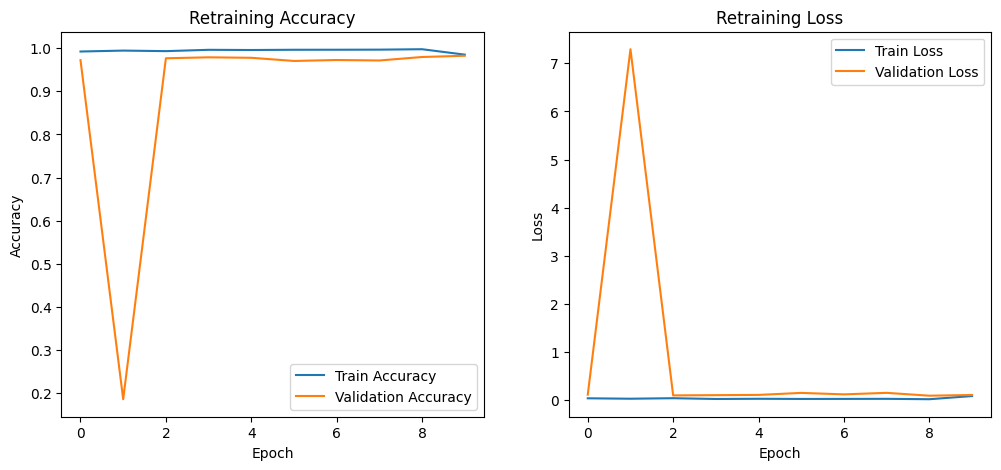

In [22]:
# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_retraining.history['accuracy'], label='Train Accuracy')
plt.plot(history_retraining.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Retraining Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_retraining.history['loss'], label='Train Loss')
plt.plot(history_retraining.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Retraining Loss')
plt.legend()

plt.show()

In [23]:
# Load and preprocess the final test set
test_data = pd.read_csv('/content/drive/MyDrive/clickbait_data.csv')

In [24]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [25]:
test_data['headline'] = test_data['headline'].apply(preprocess_text)
X_test_final = test_data['headline']
y_test_final = test_data['clickbait']
y_test_final = label_encoder.transform(y_test_final)


In [26]:
X_test_final_seq = tokenizer.texts_to_sequences(X_test_final)
X_test_final_padded = pad_sequences(X_test_final_seq, maxlen=100)

In [27]:
# Evaluate the model on the final test set
test_loss_final, test_accuracy_final = model.evaluate(X_test_final_padded, y_test_final)
print(f"Final Test accuracy: {test_accuracy_final}")

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - accuracy: 0.9887 - loss: 0.0885
Final Test accuracy: 0.9852187633514404


In [28]:
# Predict on the final test set
y_test_final_pred_probs = model.predict(X_test_final_padded)
y_test_final_pred = (y_test_final_pred_probs > 0.5).astype(int).flatten()

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 98s 98ms/step


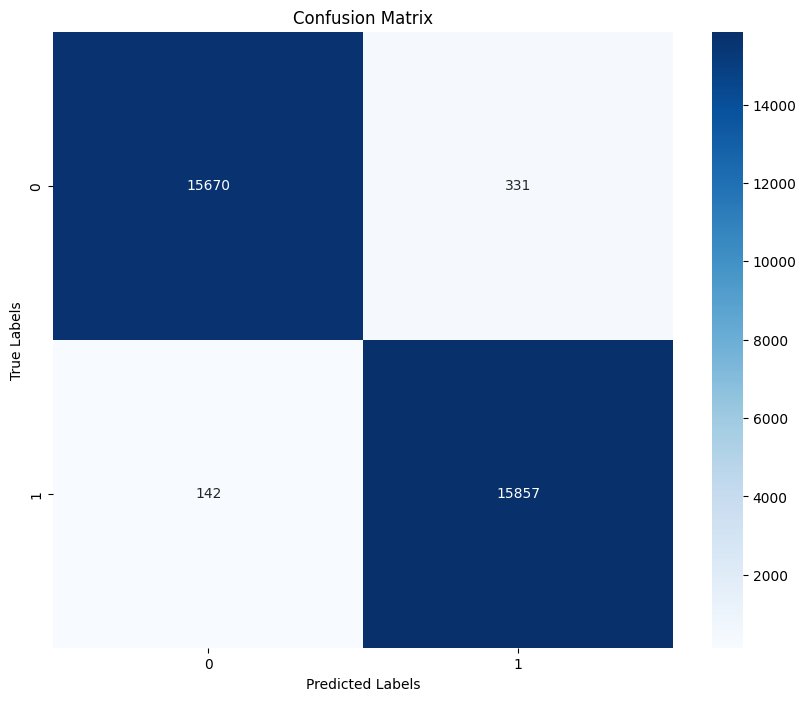

In [29]:
# Compute the confusion matrix for the final test set
conf_matrix_final = confusion_matrix(y_test_final, y_test_final_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()